In [ ]:
# Standard library imports
import os
import sys
import warnings
from pathlib import Path

# For reloading modules during development
import importlib

# Add correct directory to path to import our modules
# Check if we're in the notebooks directory or project root
current_dir = Path.cwd()
if current_dir.name == 'notebooks':
    # Running from notebooks/ directory
    sys.path.insert(0, str(current_dir.parent))
elif (current_dir / 'src').exists():
    # Running from project root
    sys.path.insert(0, str(current_dir))
else:
    # Try to find the project root
    for parent in current_dir.parents:
        if (parent / 'src').exists():
            sys.path.insert(0, str(parent))
            break
    else:
        print("Warning: Could not find src module directory")

# Debug: show where we're importing from
print(f"Working directory: {current_dir}")
print(f"Python path includes: {[p for p in sys.path if 'manifolds' in p]}")

# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Reload modules if they've been modified (useful during development)
if 'src.visualization' in sys.modules:
    importlib.reload(sys.modules['src.visualization'])
    importlib.reload(sys.modules['src.analysis'])
    importlib.reload(sys.modules['src.utils'])
    importlib.reload(sys.modules['src.datasets'])
    importlib.reload(sys.modules['src.embeddings'])
    importlib.reload(sys.modules['src.config'])
    importlib.reload(sys.modules['src'])

# Our modular imports
from src import (
    Config, 
    load_model_and_tokenizer,
    TemporalDataset, 
    TemporalDatasetCreator,
    get_control_words,
    extract_all_layer_representations,
    extract_control_embeddings,
    analyze_all_layers,
    analyze_control_temporal_across_layers,
    compute_manifold_metrics
)

from src.visualization import (
    create_layer_pca_visualization,
    plot_temporal_control_comparison,
    plot_multilayer_comparison,
    create_interactive_layer_metrics,
    create_interactive_pca_with_hover
)

from src.utils import (
    suppress_warnings,
    check_gpu_availability,
    set_random_seeds,
    save_layer_metrics_html
)

# Setup
suppress_warnings()
set_random_seeds(42)
check_gpu_availability()

# Create directory structure for saving outputs
import os
from pathlib import Path

# Define output directories
PLOTS_DIR = Path("../../../results/figures")
HTML_DIR = Path("../../../results/html")

# Create subdirectories for different plot types
plot_subdirs = {
    "pca_projections": PLOTS_DIR / "pca_projections",
    "variance_analysis": PLOTS_DIR / "variance_analysis", 
    "temporal_control": PLOTS_DIR / "temporal_control",
    "layer_metrics": PLOTS_DIR / "layer_metrics"
}

# Create all directories
for dir_path in [HTML_DIR] + list(plot_subdirs.values()):
    dir_path.mkdir(parents=True, exist_ok=True)

print("✅ All modules imported successfully!")
print(f"✅ Created output directories:")
print(f"   - {HTML_DIR}/ for HTML outputs")
for name, path in plot_subdirs.items():
    print(f"   - {path}/ for {name.replace('_', ' ')}")


Working directory: /Users/kadenzheng/manifolds/notebooks
Python path includes: ['/Users/kadenzheng/manifolds']
Warnings suppressed
Random seeds set to 42
No GPU available, using CPU
✅ All modules imported successfully!
✅ Created output directories:
   - html/ for HTML outputs
   - plots/pca/ for pca projections
   - plots/variance_analysis/ for variance analysis
   - plots/temporal_control/ for temporal control
   - plots/layer_metrics/ for layer metrics


In [2]:
# Create configuration
config = Config()

print(f"Using model: {config.model_name}")
print(f"Device: {config.device}")
print(f"Contexts: {config.contexts}")
print(f"\nContext templates:")
for ctx, template in config.CONTEXT_TEMPLATES.items():
    print(f"  {ctx}: {template}")


Using model: meta-llama/Llama-3.2-1B
Device: cpu
Contexts: ['add_sing', 'add_plur']

Context templates:
  add_sing: {} plus {} day equals {}
  add_plur: {} plus {} days equals {}


In [3]:
# Load model and tokenizer
model, tokenizer = load_model_and_tokenizer(config)

print(f"✅ Model loaded: {model.config.num_hidden_layers} layers, {model.config.hidden_size} hidden size")


Loading model: meta-llama/Llama-3.2-1B
✅ Model loaded: 16 layers, 2048 hidden size


In [4]:
# Create dataset creator
creator = TemporalDatasetCreator(config)

# Create add_sing dataset (singular)
print("=== Creating add_sing dataset ===")
add_sing_data = creator.create_dataset(contexts=['add_sing'])
add_sing_df = pd.DataFrame(add_sing_data)

# For add_sing, we only need 7 examples (one per day)
train_sing_df = add_sing_df.copy()
test_sing_df = add_sing_df.copy()

print(f"Add_sing dataset: {len(train_sing_df)} training, {len(test_sing_df)} test examples")
print("\nSample add_sing examples:")
display(add_sing_df.head())

# Create add_plur dataset (plural)
print("\n=== Creating add_plur dataset ===")
add_plur_data = creator.create_dataset(contexts=['add_plur'])
add_plur_df = pd.DataFrame(add_plur_data)

# Split add_plur into train/test
train_size = int(0.8 * len(add_plur_df))
train_plur_df = add_plur_df[:train_size].copy()
test_plur_df = add_plur_df[train_size:].copy()

print(f"Add_plur dataset: {len(train_plur_df)} training, {len(test_plur_df)} test examples")
print("\nSample add_plur examples:")
display(add_plur_df.head())

print(f"\nTotal add_sing examples: {len(train_sing_df) + len(test_sing_df)}")
print(f"Total add_plur examples: {len(train_plur_df) + len(test_plur_df)}")
print(f"Unique offsets in add_plur: {sorted(train_plur_df['offset'].unique())[:10]}...")


=== Creating add_sing dataset ===
Add_sing dataset: 7 training, 7 test examples

Sample add_sing examples:


,text,day,offset,context
0,Monday plus 1 day equals Tuesday,0,1,add_sing
1,Tuesday plus 1 day equals Wednesday,1,1,add_sing
2,Wednesday plus 1 day equals Thursday,2,1,add_sing
3,Thursday plus 1 day equals Friday,3,1,add_sing
4,Friday plus 1 day equals Saturday,4,1,add_sing



=== Creating add_plur dataset ===
Add_plur dataset: 330 training, 83 test examples

Sample add_plur examples:


,text,day,offset,context
0,Monday plus 2 days equals Wednesday,0,2,add_plur
1,Monday plus 3 days equals Thursday,0,3,add_plur
2,Monday plus 4 days equals Friday,0,4,add_plur
3,Monday plus 5 days equals Saturday,0,5,add_plur
4,Monday plus 6 days equals Sunday,0,6,add_plur



Total add_sing examples: 14
Total add_plur examples: 413
Unique offsets in add_plur: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12)]...


In [5]:
print("Running PCA analysis on all layers for add_sing and add_plur...")

# Analyze add_sing
print("\n=== ANALYZING ADD_SING DATASET - ALL LAYERS ===")
sing_results = analyze_all_layers(train_sing_df, test_sing_df, "add_sing", 
                                  model=model, tokenizer=tokenizer, config=config)

# Analyze add_plur  
print("\n=== ANALYZING ADD_PLUR DATASET - ALL LAYERS ===")
plur_results = analyze_all_layers(train_plur_df, test_plur_df, "add_plur",
                                 model=model, tokenizer=tokenizer, config=config)

print("\n✅ Analysis complete!")
print(f"  add_sing: {sing_results['num_samples']} total samples")
print(f"  add_plur: {plur_results['num_samples']} total samples")


Running PCA analysis on all layers for add_sing and add_plur...

=== ANALYZING ADD_SING DATASET - ALL LAYERS ===


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Extracting representations: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Library/Frameworks/Python.framework/Ve


=== ANALYZING ADD_PLUR DATASET - ALL LAYERS ===


Extracting representations: 100%|██████████| 26/26 [00:05<00:00,  4.95it/s]



✅ Analysis complete!
  add_sing: 14 total samples
  add_plur: 413 total samples


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/pyth

Saved: plots/pca/pca_all_layers_add_sing.png


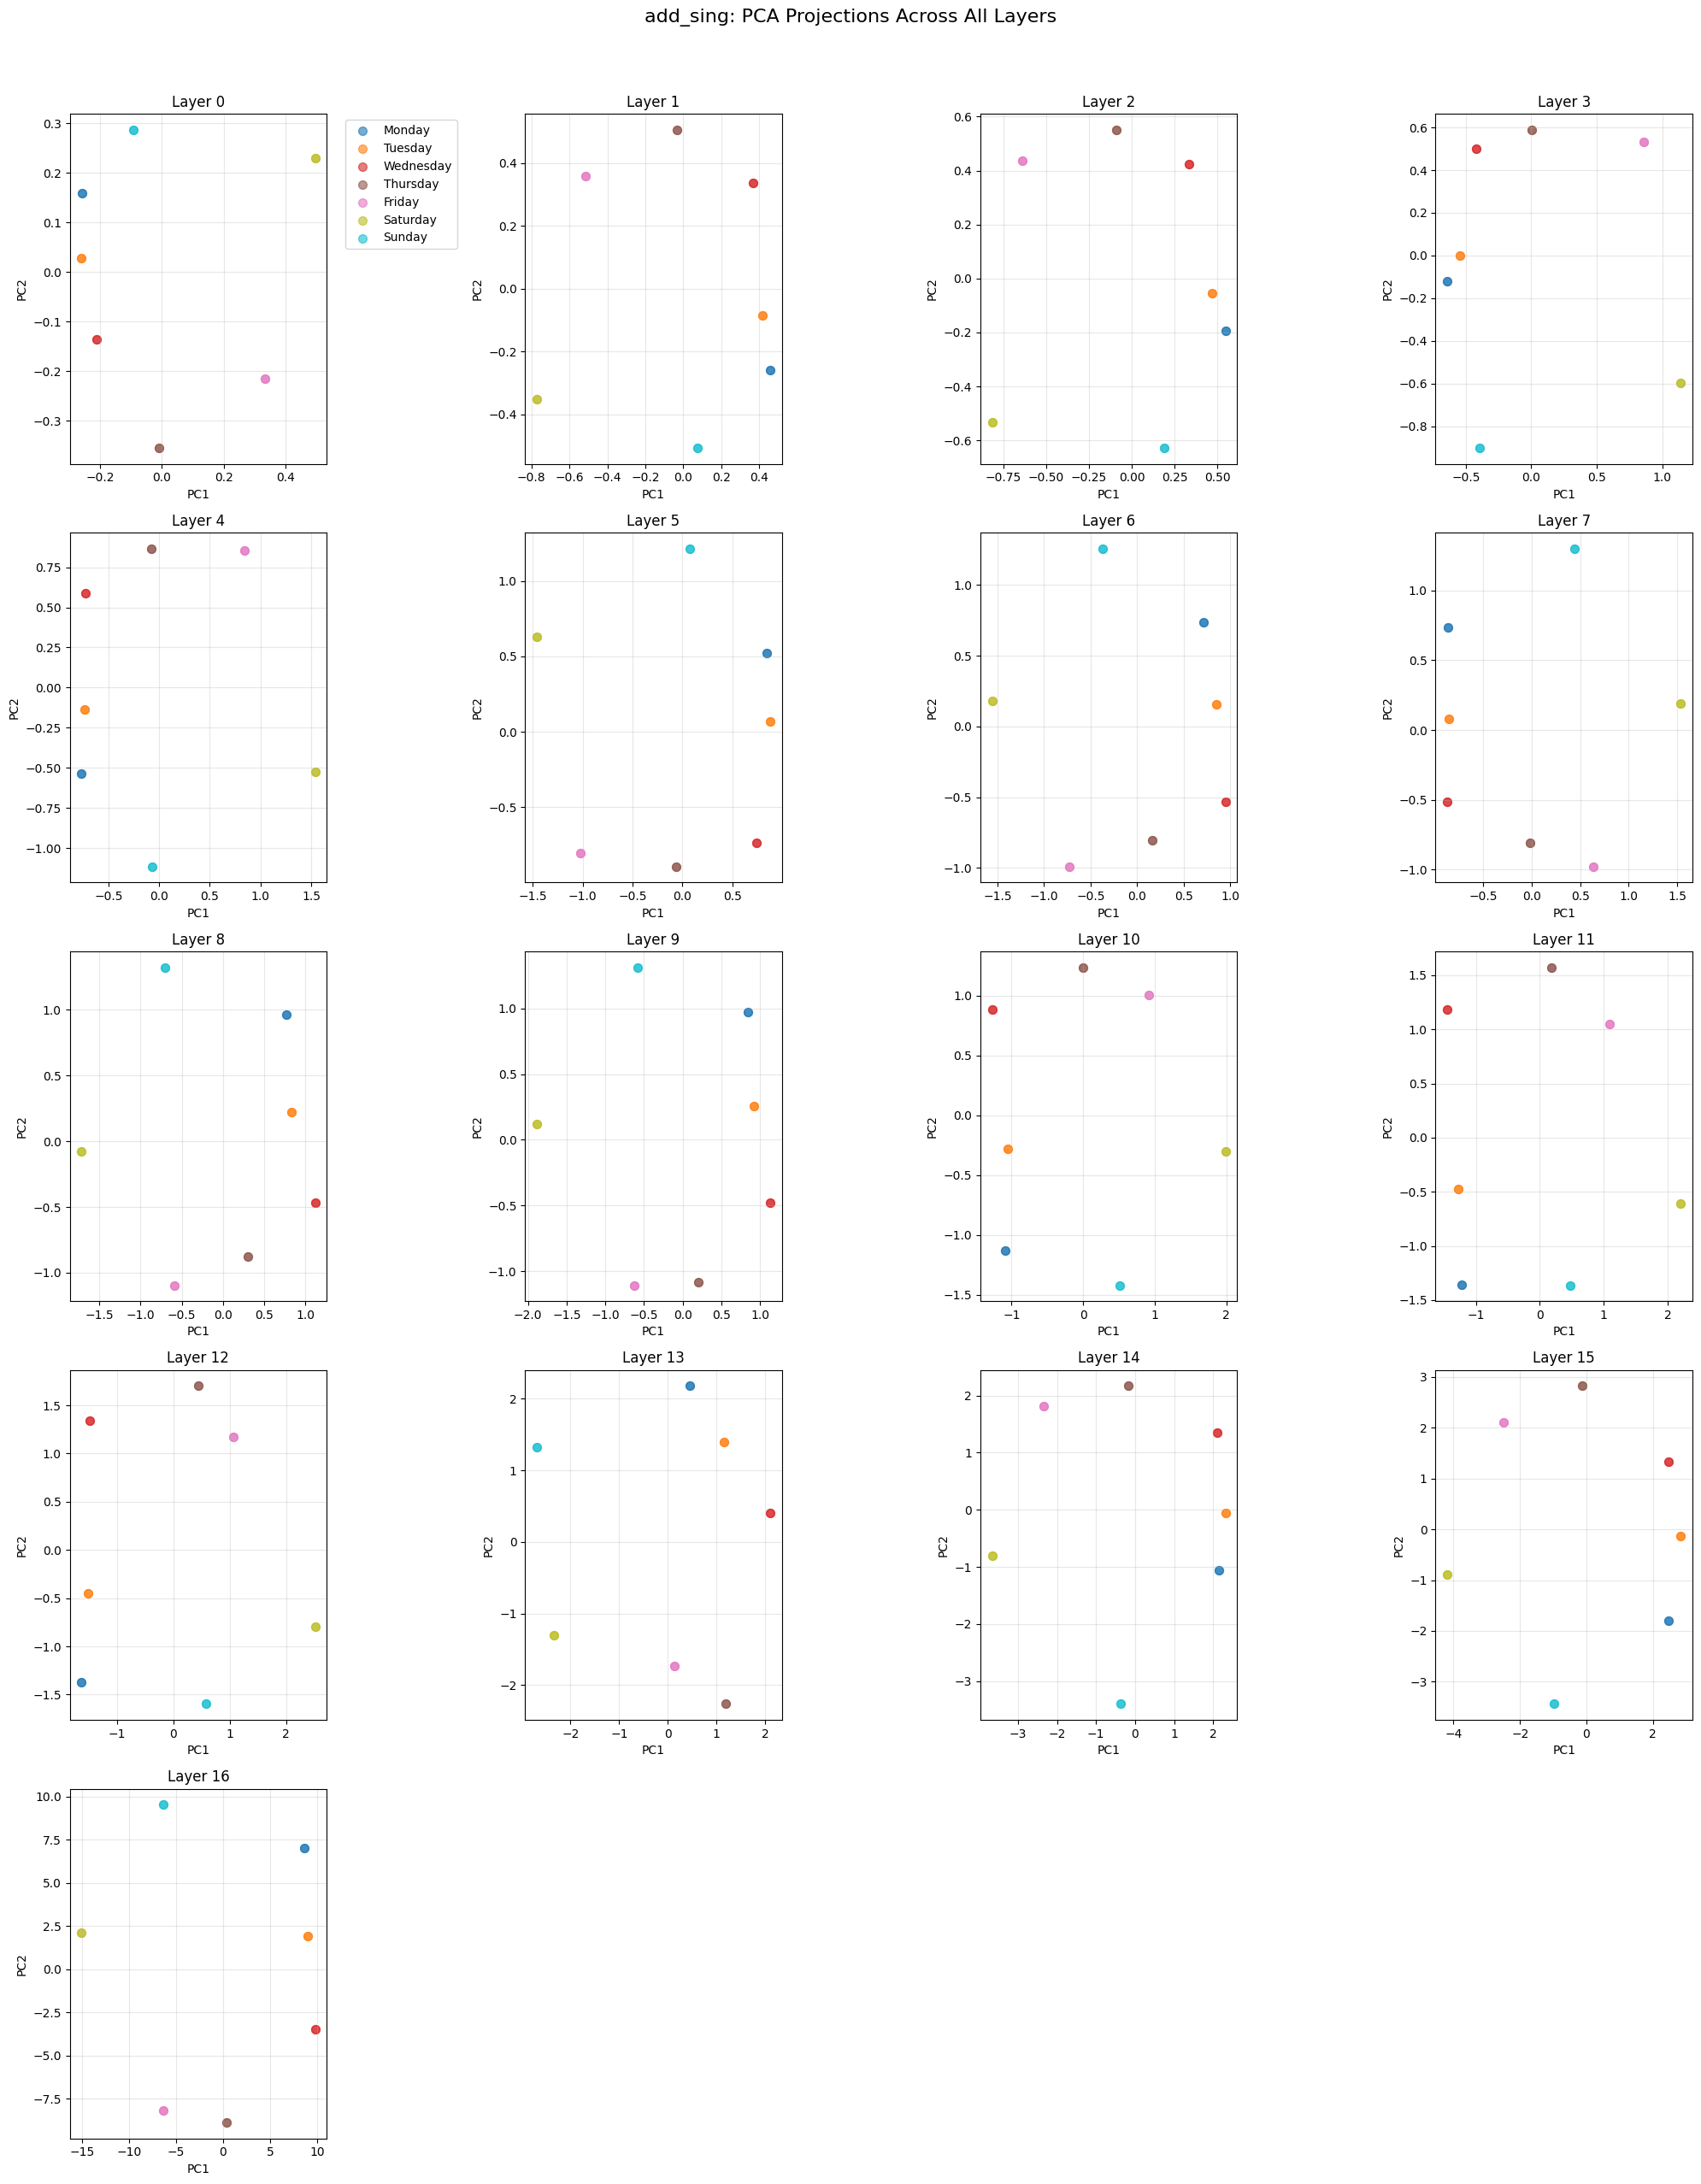

Saved: plots/pca/pca_all_layers_add_plur.png


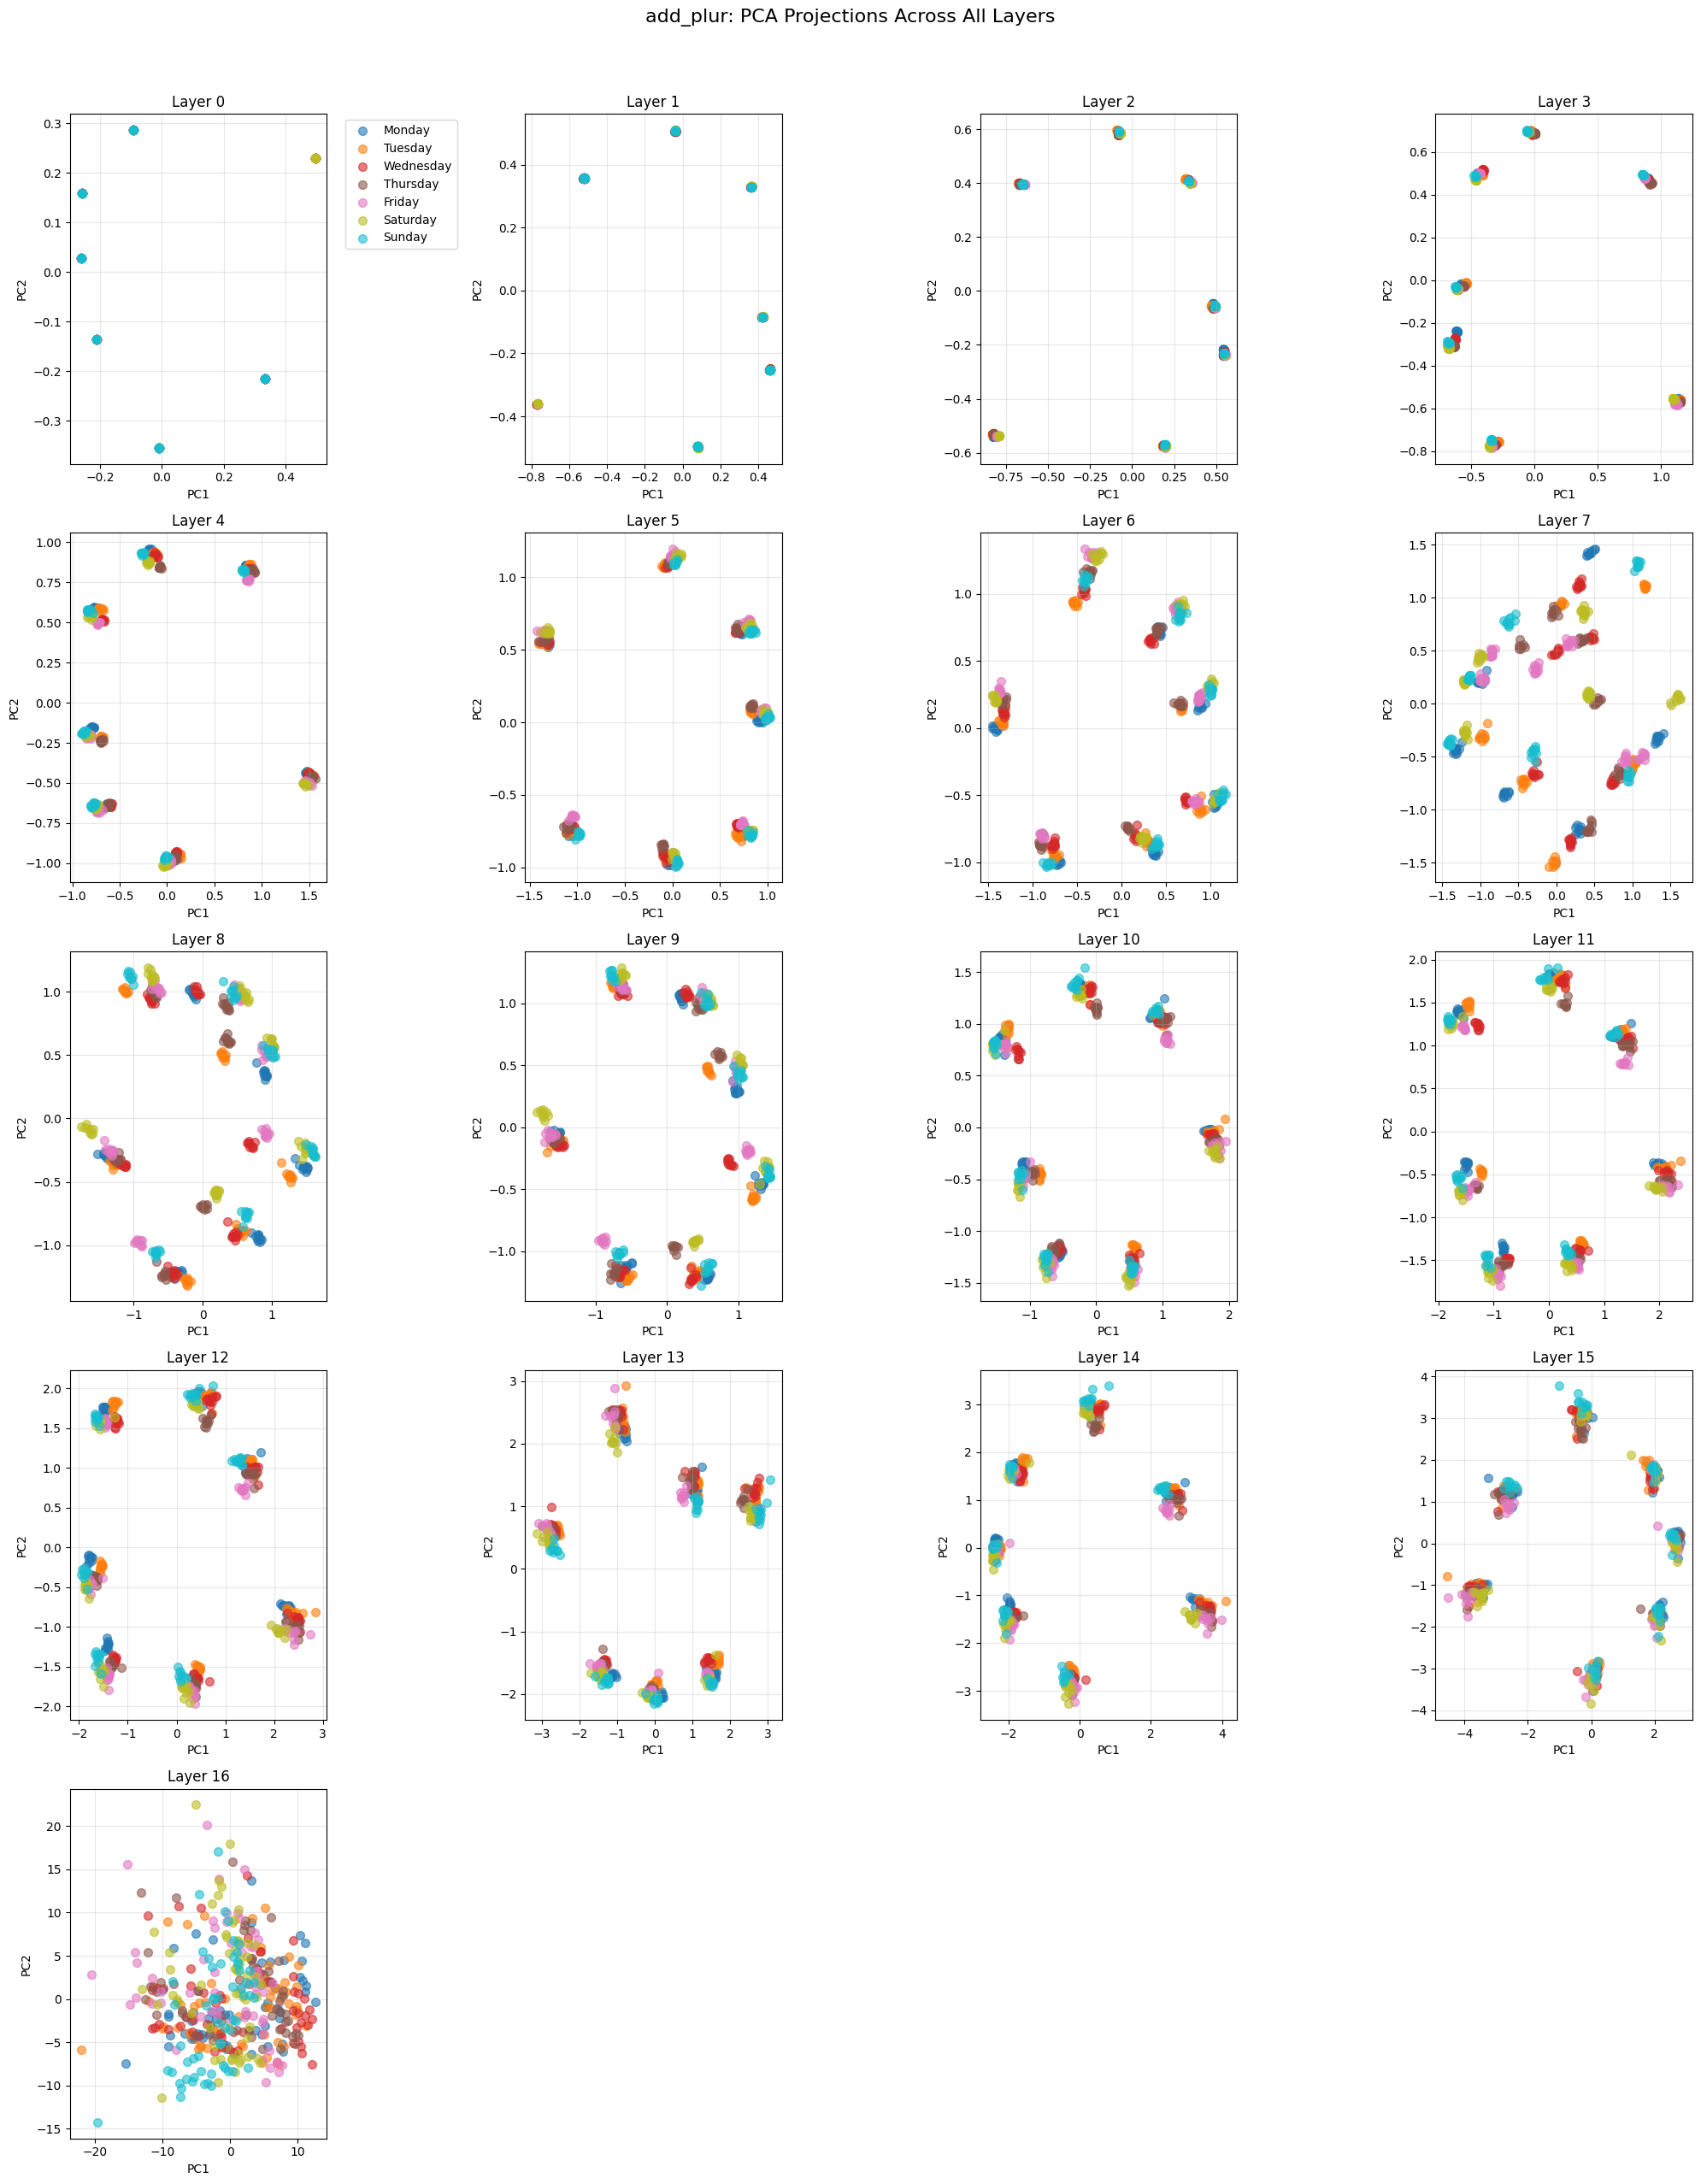

In [6]:
# Visualize add_sing
fig_sing = create_layer_pca_visualization(sing_results, 'add_sing')
sing_save_path = plot_subdirs["pca_projections"] / "pca_all_layers_add_sing.png"
fig_sing.savefig(sing_save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {sing_save_path}")
plt.show()

# Visualize add_plur
fig_plur = create_layer_pca_visualization(plur_results, 'add_plur')
plur_save_path = plot_subdirs["pca_projections"] / "pca_all_layers_add_plur.png"
fig_plur.savefig(plur_save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {plur_save_path}")
plt.show()


Saved: plots/variance_analysis/pca_variance_explained_comparison.png


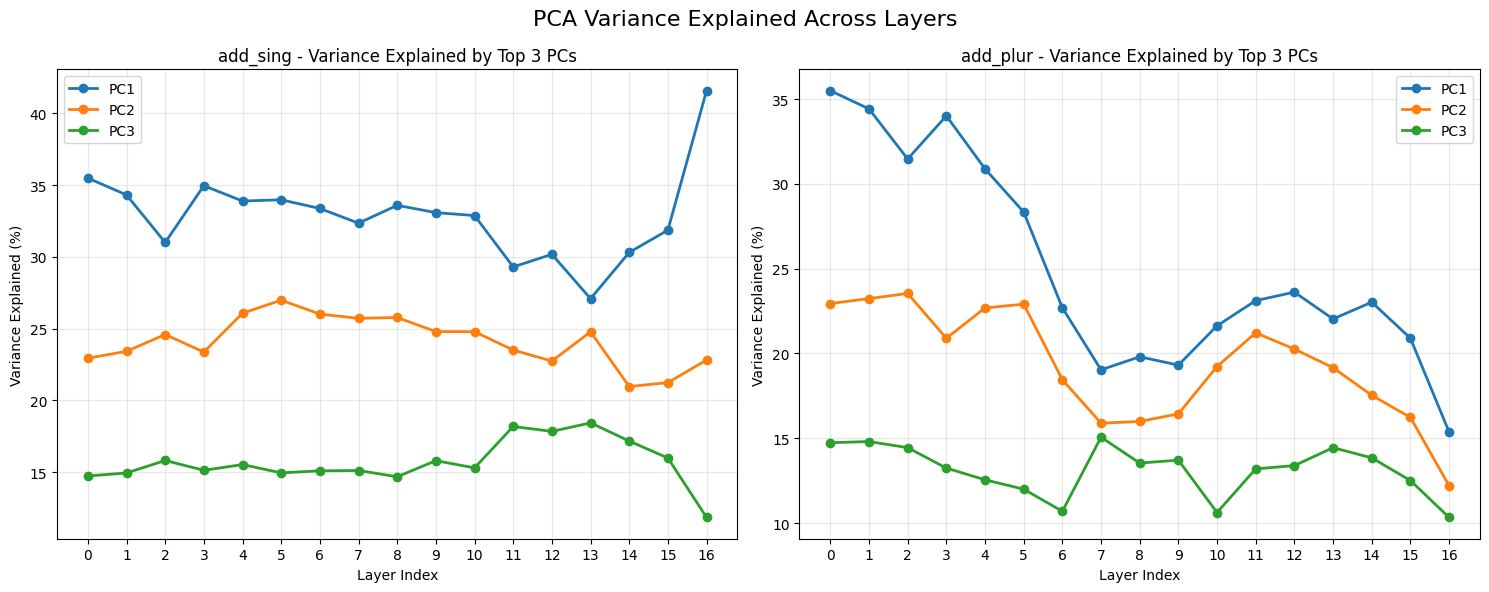

In [7]:
# Compare variance explained across layers
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

for ax, results, name in [(ax1, sing_results, 'add_sing'), (ax2, plur_results, 'add_plur')]:
    layer_indices = sorted([k for k in results.keys() if isinstance(k, int)])
    
    for i, comp_idx in enumerate([0, 1, 2]):  # First 3 components
        variance_by_layer = []
        for layer_idx in layer_indices:
            var_explained = results[layer_idx]['explained_variance']
            if comp_idx < len(var_explained):
                variance_by_layer.append(var_explained[comp_idx] * 100)
            else:
                variance_by_layer.append(0)
        
        ax.plot(layer_indices, variance_by_layer, 
                marker='o', label=f'PC{comp_idx+1}', linewidth=2)
    
    ax.set_xlabel('Layer Index')
    ax.set_ylabel('Variance Explained (%)')
    ax.set_title(f'{name} - Variance Explained by Top 3 PCs')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xticks(layer_indices)

plt.suptitle('PCA Variance Explained Across Layers', fontsize=16)
plt.tight_layout()

# Save the figure
variance_save_path = plot_subdirs["variance_analysis"] / "pca_variance_explained_comparison.png"
plt.savefig(variance_save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {variance_save_path}")
plt.show()


In [8]:
# Get control words
control_words = get_control_words()
print(f"Using {len(control_words)} control words:")
print(f"Examples: {control_words[:10]}...")

# Extract control embeddings
control_layer_representations, control_labels = extract_control_embeddings(
    control_words, model, tokenizer, config.device
)

print(f"\n✅ Extracted embeddings for {len(control_words)} control words across {len(control_layer_representations)} layers")


Using 45 control words:
Examples: ['apple', 'banana', 'orange', 'grape', 'strawberry', 'carrot', 'broccoli', 'potato', 'tomato', 'lettuce']...


Extracting representations: 100%|██████████| 2/2 [00:00<00:00,  5.44it/s]


✅ Extracted embeddings for 45 control words across 17 layers


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_

Best layer for temporal-control separation: Layer 3
Separation ratio: 0.381
Saved: plots/temporal_control/temporal_control_comparison_layer_3.png


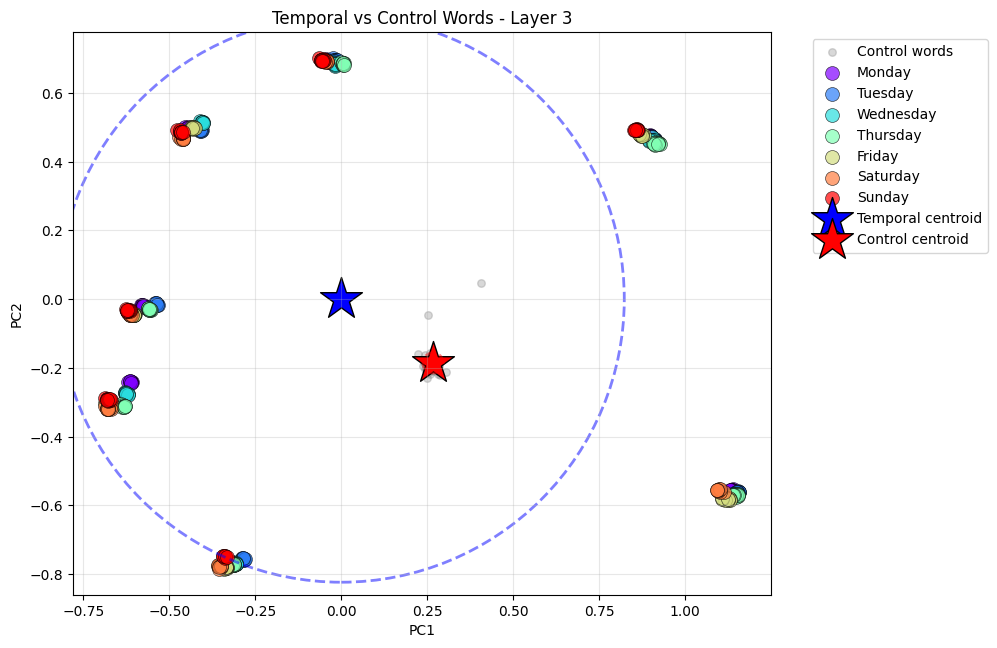

In [9]:
# Analyze temporal vs control across layers
layer_metrics = analyze_control_temporal_across_layers(
    plur_results, control_layer_representations, control_labels
)

# Find best layer
best_layer = max(layer_metrics.keys(), key=lambda k: layer_metrics[k]['separation_ratio'])
print(f"Best layer for temporal-control separation: Layer {best_layer}")
print(f"Separation ratio: {layer_metrics[best_layer]['separation_ratio']:.3f}")

# Visualize comparison at best layer
fig = plot_temporal_control_comparison(
    plur_results, control_layer_representations, control_labels, layer_idx=best_layer
)

# Save the figure
control_comp_save_path = plot_subdirs["temporal_control"] / f"temporal_control_comparison_layer_{best_layer}.png"
plt.savefig(control_comp_save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {control_comp_save_path}")
plt.show()


Saved: plots/layer_metrics/multilayer_comparison.png


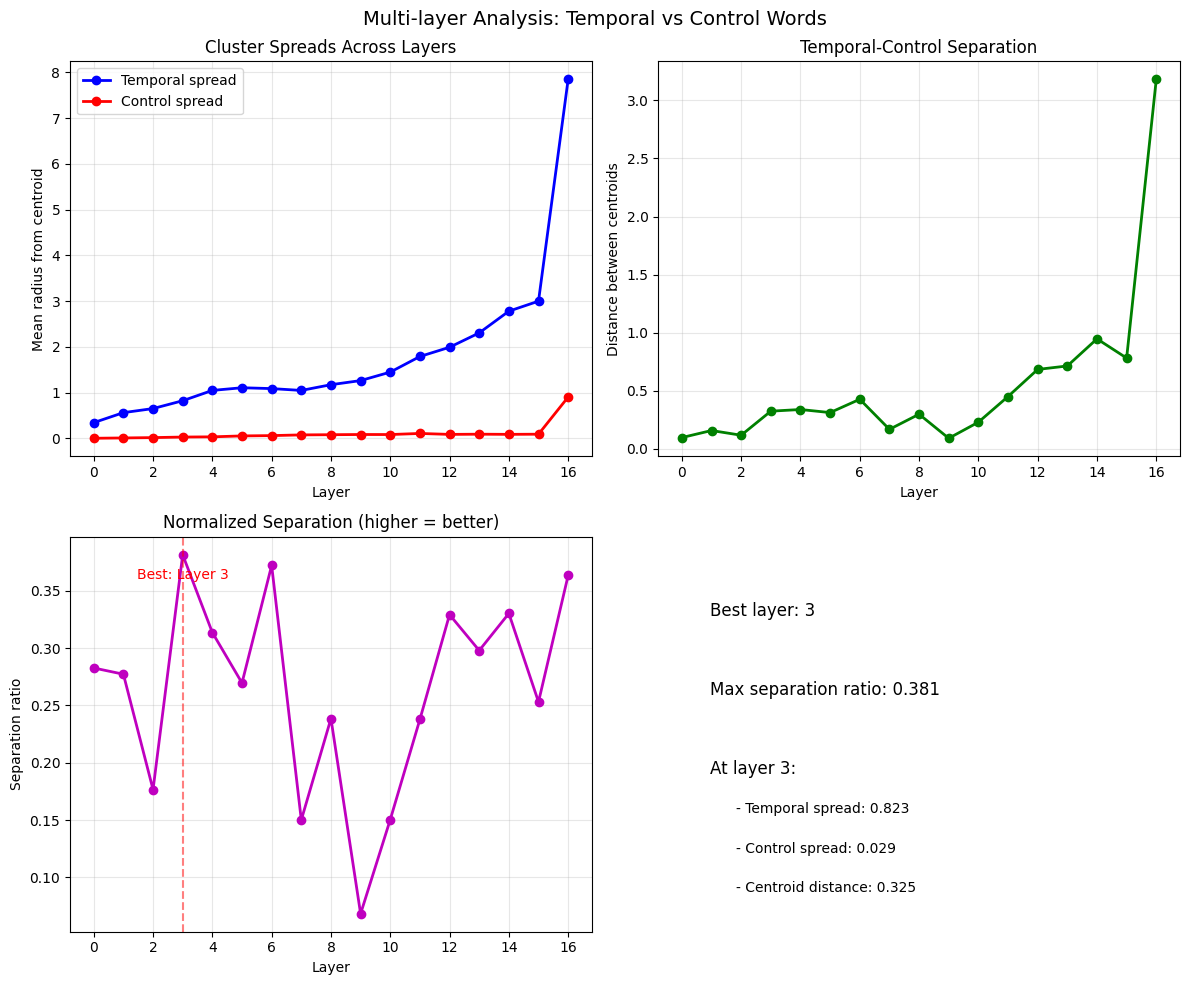

In [10]:
# Create multi-panel comparison
fig = plot_multilayer_comparison(layer_metrics)

# Save the figure
multilayer_save_path = plot_subdirs["layer_metrics"] / "multilayer_comparison.png"
plt.savefig(multilayer_save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {multilayer_save_path}")
plt.show()


In [11]:
# Create interactive layer metrics visualization
fig_interactive = create_interactive_layer_metrics(layer_metrics)
fig_interactive.show()

# Save to HTML in the html/ directory
html_save_path = HTML_DIR / "layer_metrics_interactive.html"
save_layer_metrics_html(fig_interactive, str(html_save_path))
print(f"Saved interactive visualization to: {html_save_path}")


Saved interactive plot to html/layer_metrics_interactive.html
Saved interactive visualization to: html/layer_metrics_interactive.html


In [12]:
# Create interactive PCA visualization with dropdown for layer selection
# Combine train and test data for full visualization
all_plur_df = pd.concat([train_plur_df, test_plur_df], ignore_index=True)

# Create the interactive plot
fig_pca_interactive = create_interactive_pca_with_hover(
    plur_results, 
    'add_plur',
    text_data=all_plur_df
)

# Display the plot
fig_pca_interactive.show()

# Save to HTML
pca_interactive_path = HTML_DIR / "pca_interactive_add_plur.html"
fig_pca_interactive.write_html(str(pca_interactive_path))
print(f"Saved interactive PCA visualization to: {pca_interactive_path}")


Saved interactive PCA visualization to: html/pca_interactive_add_plur.html


In [13]:
# Create cleaner interactive layer metrics visualization (overview)
fig_metrics_clean = create_interactive_layer_metrics(layer_metrics, show_individual_layers=False)
fig_metrics_clean.show()

# Save to HTML
metrics_clean_path = HTML_DIR / "layer_metrics_clean.html"
fig_metrics_clean.write_html(str(metrics_clean_path))
print(f"Saved clean metrics visualization to: {metrics_clean_path}")

# Create individual layer view with dropdown
fig_metrics_individual = create_interactive_layer_metrics(layer_metrics, show_individual_layers=True)
fig_metrics_individual.show()

# Save to HTML
metrics_individual_path = HTML_DIR / "layer_metrics_individual.html"
fig_metrics_individual.write_html(str(metrics_individual_path))
print(f"Saved individual layer metrics to: {metrics_individual_path}")


Saved clean metrics visualization to: html/layer_metrics_clean.html


Saved individual layer metrics to: html/layer_metrics_individual.html


In [14]:
# Summary of saved outputs
print("=== Summary of Saved Outputs ===")
print("\nFigures saved to:")
print(f"  - PCA projections: {plot_subdirs['pca_projections']}/")
print(f"  - Variance analysis: {plot_subdirs['variance_analysis']}/")
print(f"  - Temporal vs Control: {plot_subdirs['temporal_control']}/")
print(f"  - Layer metrics: {plot_subdirs['layer_metrics']}/")
print(f"\nHTML files saved to:")
print(f"  - {HTML_DIR}/")

# List all saved files
from pathlib import Path
print("\nAll saved files:")
for folder in [PLOTS_DIR, HTML_DIR]:
    for file in folder.rglob("*.png"):
        print(f"  - {file}")
    for file in folder.rglob("*.html"):
        print(f"  - {file}")


=== Summary of Saved Outputs ===

Figures saved to:
  - PCA projections: plots/pca/
  - Variance analysis: plots/variance_analysis/
  - Temporal vs Control: plots/temporal_control/
  - Layer metrics: plots/layer_metrics/

HTML files saved to:
  - html/

All saved files:
  - plots/pairwise_distances/distance_heatmaps_layer_16.png
  - plots/pairwise_distances/layer_evolution_metrics.png
  - plots/pairwise_distances/circular_distances_layer_16.png
  - plots/pairwise_distances/intra_cluster_comparison_layer_16.png
  - plots/temporal_control/temporal_control_comparison_layer_3.png
  - plots/pca/pca_all_layers_add_sing.png
  - plots/pca/pca_all_layers_control.png
  - plots/pca/pca_all_layers_add_plur.png
  - plots/variance_analysis/pca_variance_explained_comparison.png
  - plots/layer_metrics/multilayer_comparison.png
  - plots/circle_fitting/pca_visualization.png
  - plots/circle_fitting/r2_comparison.png
  - plots/circle_fitting/best_layer.png
  - plots/circle_fitting/radius_comparison.png

Creating control words PCA visualization...
Number of layers: 17


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Pyth

Saved: plots/pca/pca_all_layers_control.png
Also saved: ../results/figures/pca/pca_all_layers_control.png


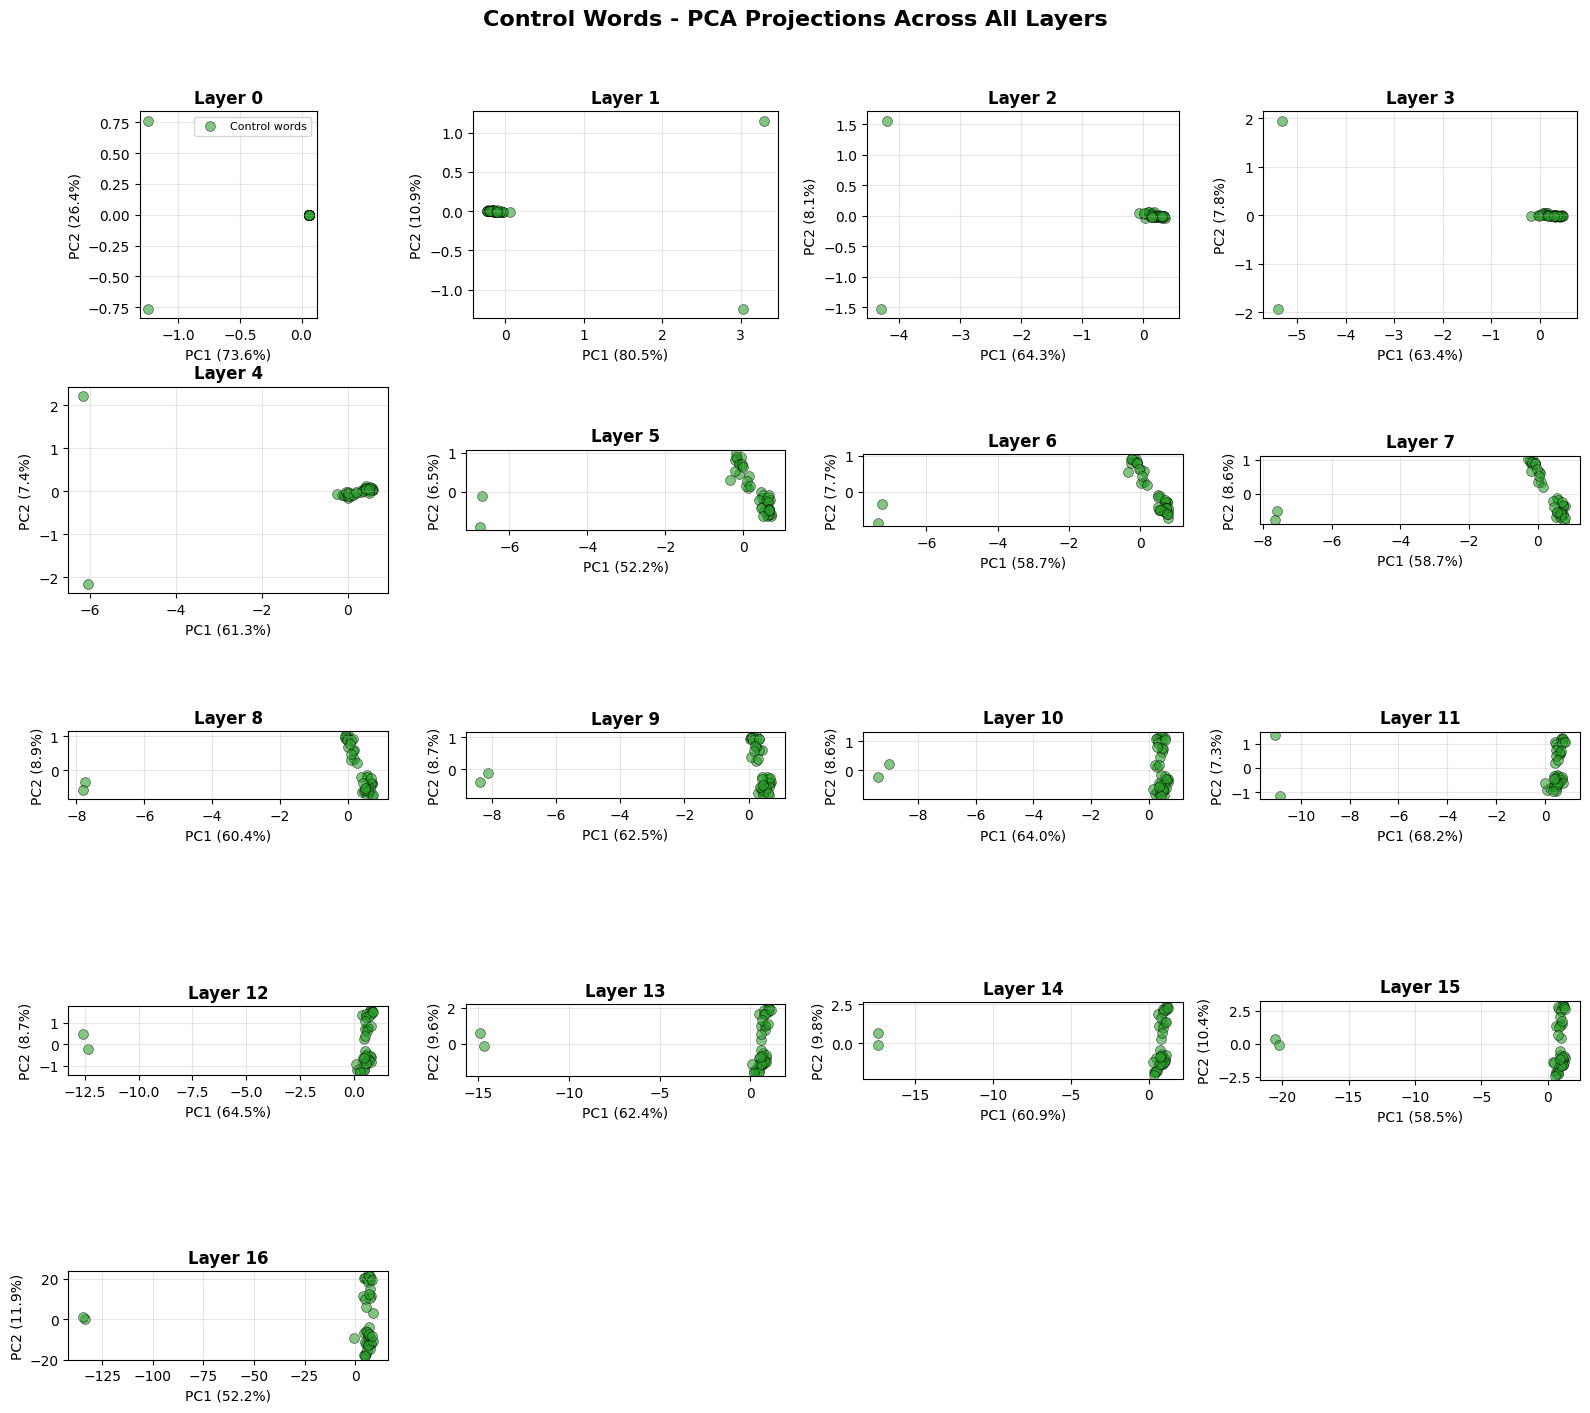

In [ ]:
# Create PCA visualization for control words (similar to add_sing and add_plur)
print("Creating control words PCA visualization...")

# Import PCA if not already imported
from sklearn.decomposition import PCA
from pathlib import Path

# Get number of layers
num_layers = len(control_layer_representations)
print(f"Number of layers: {num_layers}")

# Determine grid size
n_cols = 4
n_rows = (num_layers + n_cols - 1) // n_cols  # Ceiling division

# Create the figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
axes = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]

# Color palette for control words
control_color = '#2ca02c'  # Green color to distinguish from temporal words

# Apply PCA to each layer and plot
for layer_idx in range(num_layers):
    ax = axes[layer_idx]
    
    # Get representations for this layer
    layer_reprs = control_layer_representations[layer_idx]
    
    # Apply PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(layer_reprs)
    
    # Plot control words
    ax.scatter(pca_result[:, 0], pca_result[:, 1], 
              c=control_color, alpha=0.6, s=50, edgecolors='black', linewidth=0.5,
              label='Control words')
    
    # Add some example word labels for clarity
    # Label a subset of high-frequency words
    words_to_label = ['the', 'and', 'in', 'is', 'for', 'that', 'with', 'as', 'on', 'at']
    for word in words_to_label:
        if word in control_words:
            idx = control_words.index(word)
            if idx < len(pca_result):  # Safety check
                ax.annotate(word, 
                           (pca_result[idx, 0], pca_result[idx, 1]),
                           xytext=(5, 5), textcoords='offset points',
                           fontsize=8, alpha=0.7)
    
    # Set title and labels
    ax.set_title(f'Layer {layer_idx}', fontsize=12, fontweight='bold')
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    # Set aspect ratio
    ax.set_aspect('equal', 'box')
    
    # Add legend only to first subplot
    if layer_idx == 0:
        ax.legend(loc='best', fontsize=8)

# Remove any unused subplots (if model has less than 16 layers)
for idx in range(num_layers, len(axes)):
    fig.delaxes(axes[idx])

# Add main title
fig.suptitle('Control Words - PCA Projections Across All Layers', 
             fontsize=16, fontweight='bold', y=0.98)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.96])

# Save the figure
control_save_path = plot_subdirs["pca_projections"] / "pca_all_layers_control.png"
plt.savefig(control_save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {control_save_path}")

# Also save to results directory
results_save_path = Path("../../../results/figures/pca/pca_all_layers_control.png")
results_save_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(results_save_path, dpi=300, bbox_inches='tight')
print(f"Also saved: {results_save_path}")

plt.show()
